<a href="https://colab.research.google.com/github/leticiaram/Modelacion-Epidemiologica/blob/main/4_2_UQ_SIR_Metropolis_Hasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Instalando y cargando paquetes

In [2]:
import scipy.integrate as spi
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pylab as pl

from scipy.integrate import odeint
from scipy import stats
import scipy.stats
from scipy.stats import truncnorm

In [3]:
#import os
#import sys
#import glob

plt.style.use('ggplot')

# Modelo SIR

El modelo es
\begin{equation}
    \begin{split}
		\dot{S} &= -\beta S \frac{I}{N}\\
   	\dot{I} &= \beta S \frac{I}{N}-\gamma I\\
   	\dot{R} &= \gamma I\\
    \end{split}
\end{equation}
donde $\beta, \gamma>0$.

In [4]:
def ode_SIR(INP,t,ps):
    try:
        beta = ps['beta'].value
        gamma = ps['gamma'].value
        N = ps['N'].value
    except:
        beta, gamma, N = ps

    Y = np.zeros((3))
    V = INP
    Y[0] = - beta * V[0] * V[1] /N
    Y[1] = beta * V[0] * V[1]/N - gamma * V[1]
    Y[2] = gamma * V[1]
    return Y


# Solución Numérica del Modelo

In [5]:
def g(t,INP,ps):
    SOL = spi.odeint(ode_SIR,INPUT,t_range,args=(ps,))
    return [t_range,SOL[:,0],SOL[:,1],SOL[:,2]]

# Simulamos datos de **incidencia**

In [6]:
beta = 1.42
gamma = 0.142
N = 1000
true_theta = np.array((beta, gamma, N))

S0 = 1000-1
I0 = 1
INPUT = (S0, I0, 0.0)

t_start = 0.0; t_end = 30; t_inc = 1.0
t_range = np.arange(t_start, t_end+t_inc, t_inc)

In [7]:
data = g(t_range, INPUT, true_theta)

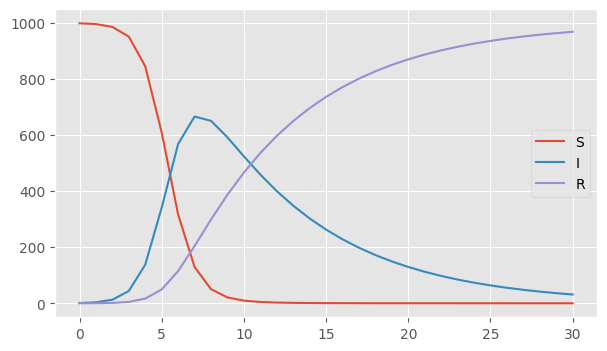

In [8]:
t_range, S, I, R = data
plt.figure(figsize=(7, 4))
plt.plot(t_range,S, label='S')
plt.plot(t_range,I, label='I')
plt.plot(t_range,R, label='R')
plt.legend(loc="best")
plt.show()

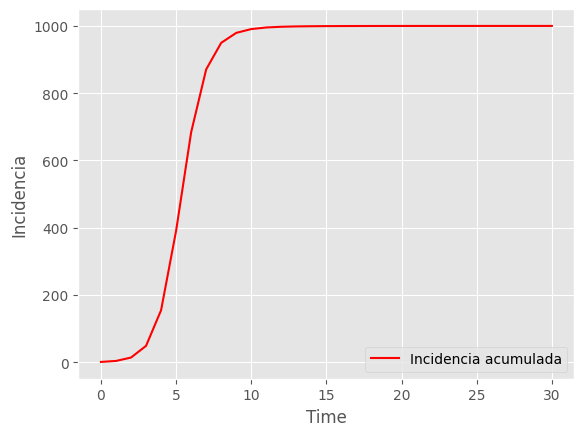

In [9]:
incidencia_acumulada = N-S
#Ploting
pl.plot(incidencia_acumulada, '-r', label='Incidencia acumulada')
pl.legend(loc=0)
pl.xlabel('Time')
pl.ylabel('Incidencia')
pl.show()

Obtenemos la incidencia diaria

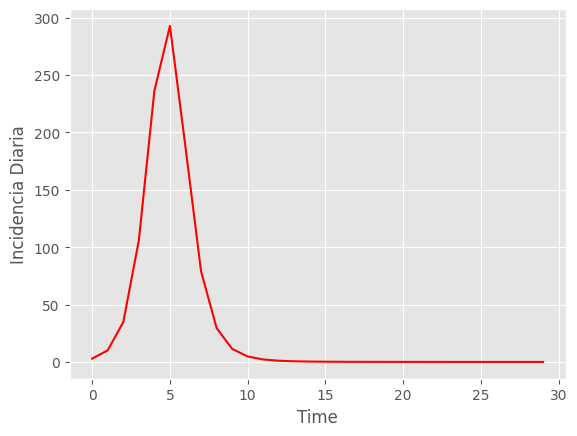

In [10]:
incidencia_diaria = np.diff(incidencia_acumulada)
#Ploting
pl.plot(incidencia_diaria, '-r')
pl.xlabel('Time')
pl.ylabel('Incidencia Diaria')
pl.show()

Añadimos ruido a través de una distribución Poisson

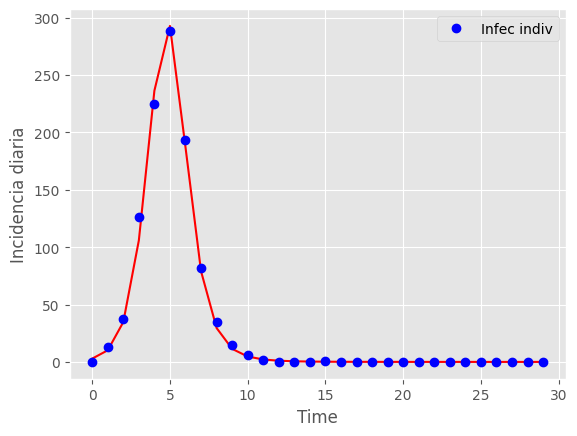

In [11]:
np.random.seed(34)
data = np.random.poisson(lam=incidencia_diaria, size=incidencia_diaria.shape[0])

#Ploting
pl.plot(incidencia_diaria, '-r')
pl.plot(data, 'bo', label='Infec indiv')
pl.legend(loc=0)
pl.xlabel('Time')
pl.ylabel('Incidencia diaria')
pl.show()

# Metropolis-Hasting

## *A priori*

In [12]:
# Log previa
def logprevia(theta):
    be, ga, n = theta
    dbe = scipy.stats.gamma.logpdf(be,par1[0],par1[1],par1[2])
    dga = scipy.stats.gamma.logpdf(ga,par2[0],par2[1],par2[2])
    return(dbe+dga)

La parametrización de la densidad que scipy considera es
$$
f(x, \alpha, \beta)=\frac{\beta^\alpha x^{\alpha-1} e^{-\beta x}}{\Gamma(\alpha)}
$$
con el comando gamma.pdf(x, a, loc, scale), donde 'a' corresponde a $\alpha$ y 'loc' =0 y scale = $1 / \beta$.

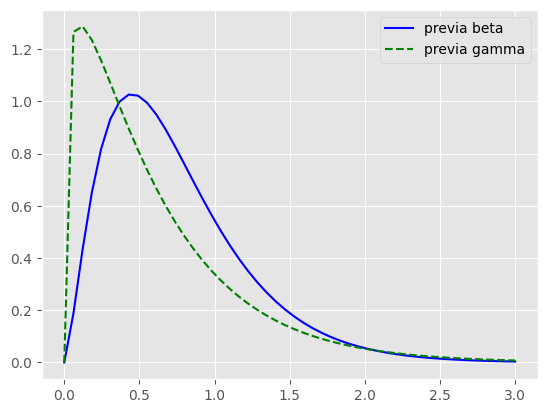

In [13]:
par1=[2.5,0,0.3]  #hiperpar'ametros para beta
par2=[1.2,0,0.5]  #hiperpar'ametros para gamma

x = np.linspace(0., 3., 50)

prev1 = scipy.stats.gamma.pdf(x, par1[0],par1[1],par1[2])
prev2 = scipy.stats.gamma.pdf(x, par2[0],par2[1],par2[2])

plt.plot(x, prev1, 'b-', label='previa beta')
plt.plot(x, prev2, 'g--', label='previa gamma')
plt.legend(loc="best")

## Verosimilitud

In [14]:
#### Log verosimilitud
def logverosimilitud(theta, t_range):
  t_sol, S_sol, I_sol, R_sol  = g(t_range, INPUT, theta)
  ### Incidencia
  Inc = np.diff(theta[2]-S_sol)
  vers = scipy.stats.poisson.logpmf(data, Inc)
  ver = np.sum(vers)
  return(ver)


In [223]:
data

array([  0,  13,  37, 126, 225, 288, 193,  82,  35,  15,   6,   2,   0,
         0,   0,   1,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0])

In [224]:
logverosimilitud(true_theta,t_range=t_range)

np.float64(-41.34033311857333)

## *A posteriori*

In [15]:
#### Log Posterior
def logposterior(theta,t_range):
  return(logprevia(theta)+logverosimilitud(theta,t_range))

In [16]:
def posterior(theta,t_range):
    return(np.exp(logprevia(theta)+logverosimilitud(theta,t_range)))

In [17]:
print(true_theta)
print(logprevia(true_theta))
print(logverosimilitud(true_theta,t_range))
print(logposterior(true_theta,t_range))

[1.42e+00 1.42e-01 1.00e+03]
-1.2393338231725837
-41.34033311857333
-42.57966694174591


## Kernel de propuesta

In [18]:
scipy.stats.gamma.rvs(0.6,0,1)

np.float64(1.1102099397768987)

In [19]:
# Genera las propuestas
def rkernelprop(present, sd, size=1):
    myclip_a = 0
    myclip_b = 1e10
    a, b = (myclip_a - present) / sd, (myclip_b - present) / sd
    proposal = truncnorm.rvs(a,b,loc = present, scale = sd, size=size)
    return(proposal)

# Reporta la densidad de la propuesta
def dkernelprop(prop,present,sd):
    myclip_a = 0
    myclip_b = 1e10
    a, b = (myclip_a - present) /sd, (myclip_b - present) / sd
    denproposal = truncnorm.pdf(prop, a, b, loc = present, scale = sd)
    return(denproposal)

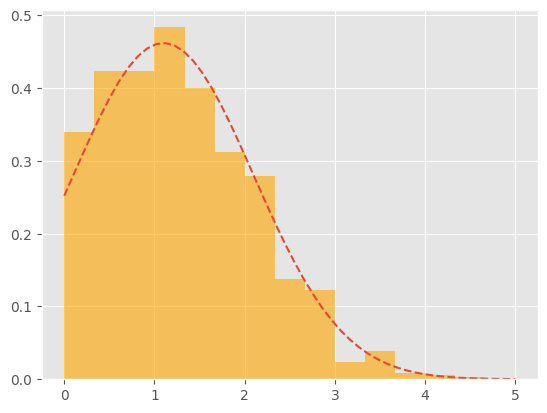

In [20]:
sims = rkernelprop(present = 1.1, sd = 1, size = 1000)
plt.hist(sims, 14 , density = True,  histtype ='bar',
         color ='orange', alpha = 0.6)
x = np.linspace(0., 5., 50)
plt.plot(x, dkernelprop(x,1.1,1), '--')

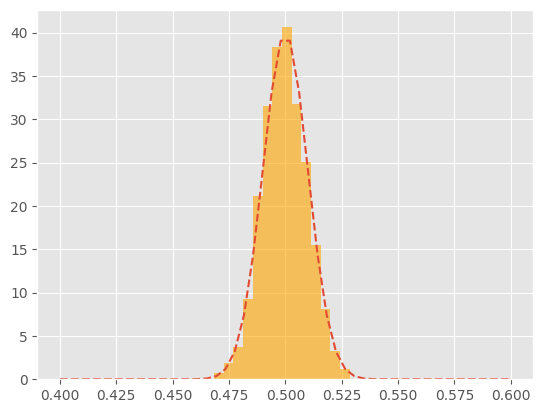

In [21]:
sims = rkernelprop(present = 0.5, sd = 0.01, size = 1000)
plt.hist(sims, 14 , density = True,  histtype ='bar',
         color ='orange', alpha = 0.6)
x = np.linspace(.4, .6, 50)
plt.plot(x, dkernelprop(x,0.5,0.01), '--')

## Inicializar los parámetros

In [22]:
def inicializa():
  flag=False
  while flag==False:
    a = scipy.stats.gamma.rvs(par1[0],par1[1],par1[2])
    b = scipy.stats.gamma.rvs(par2[0],par2[1],par2[2])
    tt = np.array([a, b, N])
    if posterior(tt, t_range)>0:
      theta_ini = tt
      flag=True
  return(theta_ini)

Estamos asumendo que ya tenemos definido:

    par1=[2.5,0,0.3]  #hiperpar'ametros para beta
    par2=[1.2,0,0.5]  #hiperpar'ametros para gamma

In [23]:
tt = inicializa()
tt

array([1.83956715e+00, 4.16604551e-01, 1.00000000e+03])

## Run the HM

In [24]:
def MH(iters, theta_ini, sd):
    theta_act = theta_ini

    be_v = np.zeros(iters)          ## guardar cadenas de betas
    ga_v = np.zeros(iters)          ##guardar cadenas de gammas
    logposter_v = np.empty(iters)   ##guardar todas las posteriores

    ### primer entrada de cada cadena
    logposter_v[0] = logposterior(theta_act,t_range=t_range)
    theta_prop = [0., 0., N]
    actualizo = 0

    for i in range(1,iters):
        ### empieza propuesta
        theta_prop[0] = rkernelprop(present = theta_act[0], sd = sd, size=1)[0]
        theta_prop[1] = rkernelprop(present = theta_act[1], sd = sd, size=1)[0]
        #print(theta_prop)

        # alfa
        qxy = dkernelprop(theta_act[0], theta_prop[0],sd) * dkernelprop(theta_act[1], theta_prop[1],sd)  #centrada en propuesto
        qyx = dkernelprop(theta_prop[0],theta_act[0],sd) * dkernelprop(theta_prop[1],theta_act[1],sd)    #centrada en actual

        lognum = logposterior(theta_prop,t_range=t_range)+np.log(qxy)
        logden = logposterior(theta_act,t_range=t_range)+np.log(qyx)
        razon = np.exp(lognum - logden)
        A = min(1,razon)
        #print(A)
        #print(posterior(theta_prop), posterior(theta_act))

        if np.random.uniform(0,1,1)<A: # actualiza
          be_v[i] = theta_prop[0]
          ga_v[i] = theta_prop[1]
          logposter_v[i] = logposterior(theta_prop,t_range=t_range)
          theta_act = theta_prop.copy()
          actualizo += 1
        else: # no actualiza
          be_v[i] = theta_act[0]
          ga_v[i] = theta_act[1]
          logposter_v[i] = logposter_v[i-1]

    rechazo = iters-actualizo
    theta = np.array([be_v, ga_v])
    return(theta, logposter_v, rechazo, actualizo)


In [26]:
np.random.seed(478)
iters = 20000

sims, logpost, rechazo, actualizo= MH(iters = iters, theta_ini = tt, sd = 0.01)
%timeit sims

17.9 ns ± 3.83 ns per loop (mean ± std. dev. of 7 runs, 100000000 loops each)


In [27]:
print('rechazó: ',rechazo)
print('actualizó: ',actualizo)
print('Porcentaje de aceptación:',actualizo/iters*100 )

rechazó:  7451
actualizó:  12549
Porcentaje de aceptación: 62.745


## Resultados

In [28]:
a=[0,0]
print(a)
a[0]=rkernelprop(present = 0.47644143, sd = 0.001, size=1)[0]
a[1]=rkernelprop(present = 0.57644143, sd = 0.001, size=1)[0]
#print(ff)
print(a)

[0, 0]
[np.float64(0.4781916171699823), np.float64(0.5749916165406345)]


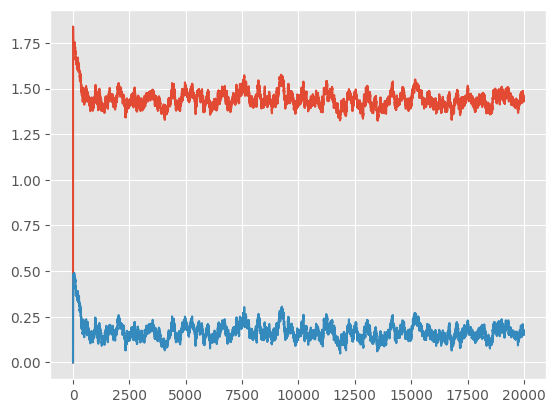

In [29]:
sims.shape
for i in range(2):
  plt.plot(sims[i,:])

In [30]:
warmup = 2000

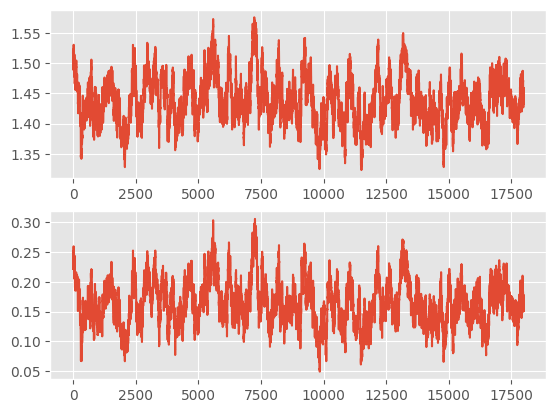

In [31]:
fig, ax = plt.subplots(2,1)
for i in range(2):
  ax[i].plot(sims[i,warmup:iters])

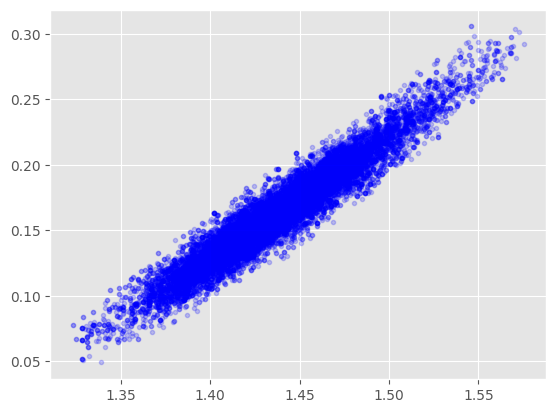

In [32]:
plt.plot(sims[0,warmup+1:].tolist(),sims[1,warmup+1:].tolist(),'.',alpha=0.2, color='blue')

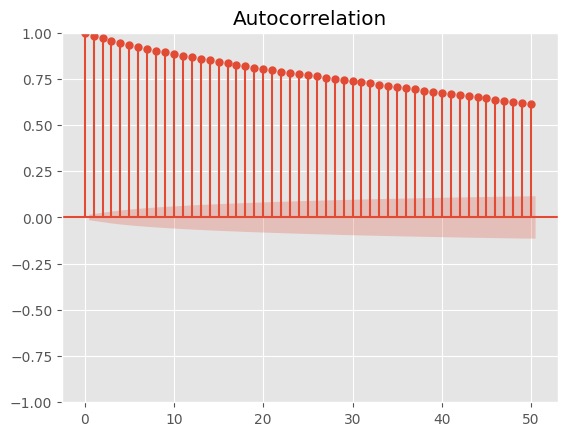

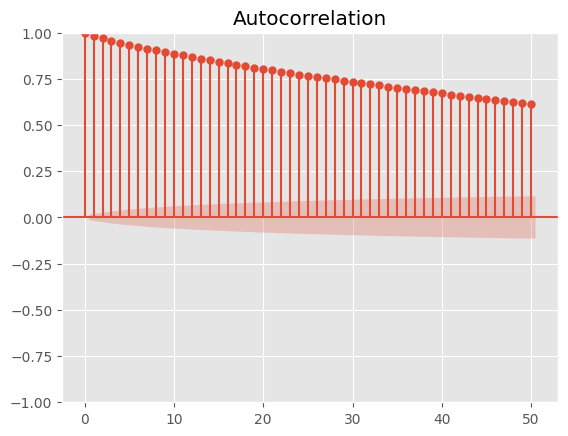

In [34]:
from statsmodels.graphics.tsaplots import plot_acf

plot_acf(sims[0,warmup+1:].tolist(), lags=50);
plot_acf(sims[1,warmup+1:].tolist(), lags=50);

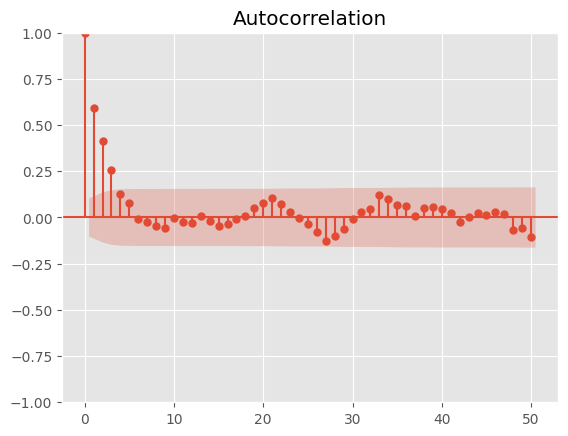

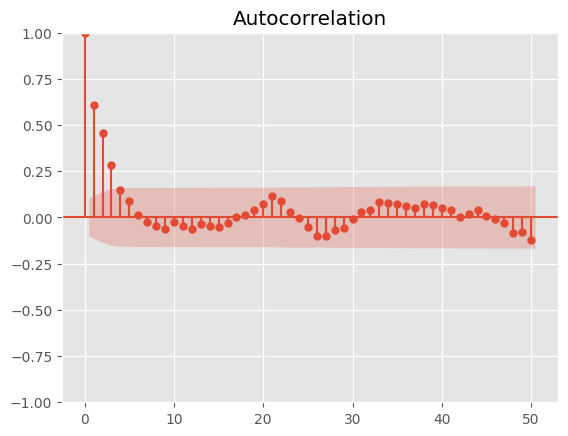

In [35]:
plot_acf(sims[0,warmup+1:iters:50].tolist(), lags=50);
plot_acf(sims[1,warmup+1:iters:50].tolist(), lags=50);

In [36]:
#El tamaño efectivo
sims[0,warmup+1:iters:50].shape[0]

360

## Graficar incidencia real y ajustadas

In [37]:
sims_hm=sims[:,warmup:iters:50]
curvas_aceptadas = np.zeros([sims_hm.shape[1],len(t_range)-1])

for i in range(sims_hm.shape[1]):
  t_range, S, I, R = g(t_range, INPUT, [sims[0,i],sims[1,i],N])
  incidencia_acumulada = N-S
  incidencia_diaria = np.diff(incidencia_acumulada)
  curvas_aceptadas[i,:]=incidencia_diaria


In [39]:
curvas_aceptadas


array([[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [4.04982032e+00, 1.64186309e+01, 6.20147167e+01, ...,
        3.48968629e-03, 2.35489033e-03, 1.58922492e-03],
       [4.04982032e+00, 1.64186309e+01, 6.20147167e+01, ...,
        3.48968629e-03, 2.35489033e-03, 1.58922492e-03],
       ...,
       [3.01669700e+00, 1.05026803e+01, 3.52459794e+01, ...,
        1.77455191e-02, 1.38127140e-02, 1.07670595e-02],
       [3.01455949e+00, 1.05055914e+01, 3.52901353e+01, ...,
        1.76126968e-02, 1.37410303e-02, 1.07367284e-02],
       [2.98371557e+00, 1.03442514e+01, 3.45969718e+01, ...,
        1.79464770e-02, 1.40585845e-02, 1.10312536e-02]])

In [38]:
print(true_theta)

[1.42e+00 1.42e-01 1.00e+03]


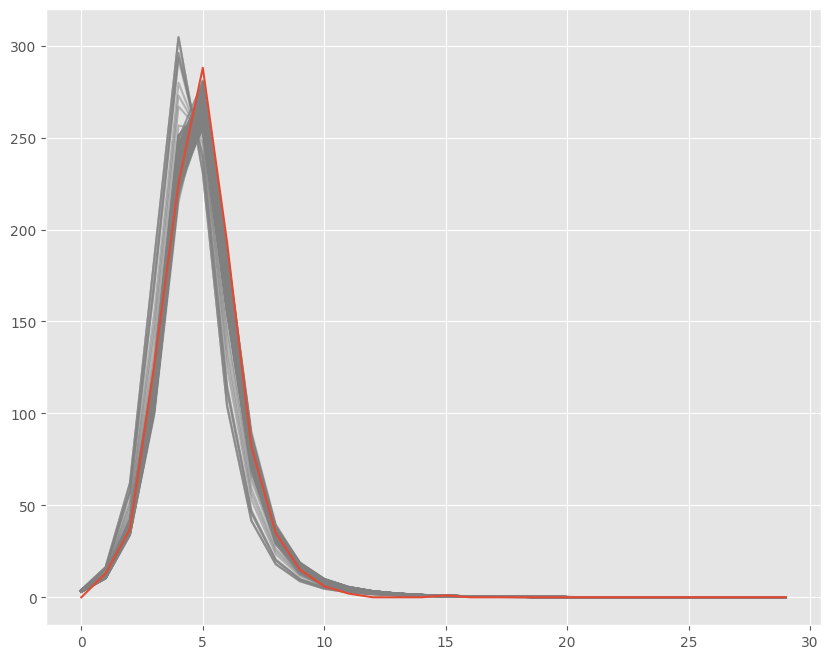

In [40]:
vt = len(t_range)-1
plt.figure(figsize=(10, 8))
for i in range(1, sims_hm.shape[1]):
  plt.plot(curvas_aceptadas[i,:],color="grey",alpha=0.5)
plt.plot(data)

In [41]:
sims_hm_df=pd.DataFrame(sims_hm.T)
# Get summaries
theta_summary = sims_hm_df.describe()

print("Summary of theta_mcmc:")
print(theta_summary)

Summary of theta_mcmc:
                0           1
count  360.000000  360.000000
mean     1.437277    0.163563
std      0.039217    0.038136
min      1.339036    0.048998
25%      1.412073    0.137654
50%      1.433030    0.160114
75%      1.466494    0.190290
max      1.552876    0.280361


Intervalos de credibilidad (percentiles)

In [43]:
# Calculate the 95% credible intervals
theta_lower_bounds = np.percentile(sims_hm.T, 2.5, axis=0)
theta_upper_bounds = np.percentile(sims_hm.T, 97.5, axis=0)
print('theta_2.5=',  theta_lower_bounds)
print('theta_97.5=', theta_upper_bounds)

theta_2.5= [1.36484645 0.09598944]
theta_97.5= [1.51641073 0.24703557]


In [255]:
true_theta

array([1.42e+00, 1.42e-01, 1.00e+03])

Media

In [44]:
print('media beta=',np.mean(sims_hm[0]))
print('media gamma=',np.mean(sims_hm[1]))


media beta= 1.4372773866977437
media gamma= 0.1635630579205366
